In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


In [101]:
# Load and flatten nested fields
df = pd.read_json('/content/user-wallet-transactions.json')
df = pd.json_normalize(df.to_dict(orient="records"))

# Parse timestamps safely
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
if 'createdAt.$date' in df.columns:
    df['createdAt'] = pd.to_datetime(df['createdAt.$date'], errors='coerce')


In [102]:
# Rename and clean important fields
df.rename(columns={
    'userWallet': 'wallet_address',
    'actionData.amount': 'amount',
    'actionData.assetPriceUSD': 'price_usd',
    'actionData.assetSymbol': 'asset_symbol'
}, inplace=True)

df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df['price_usd'] = pd.to_numeric(df['price_usd'], errors='coerce')
df['usd_value'] = df['amount'] * df['price_usd']

# Drop rows with critical nulls
df.dropna(subset=['wallet_address', 'amount', 'price_usd', 'timestamp'], inplace=True)
df.fillna({'asset_symbol': 'UNKNOWN'}, inplace=True)


In [103]:
agg_df = df.groupby('wallet_address').agg(
    total_tx=('txHash', 'count'),
    total_usd=('usd_value', 'sum'),
    mean_usd=('usd_value', 'mean'),
    std_usd=('usd_value', 'std'),
    unique_tokens=('asset_symbol', 'nunique'),
    unique_actions=('action', 'nunique'),
    first_tx=('timestamp', 'min'),
    last_tx=('timestamp', 'max')
).reset_index()

# Compute duration metrics
agg_df['active_days'] = (agg_df['last_tx'] - agg_df['first_tx']).dt.days + 1
agg_df['tx_per_day'] = agg_df['total_tx'] / agg_df['active_days'].replace(0, 1)
agg_df['std_usd'].fillna(0, inplace=True)


/tmp/ipython-input-103-816908558.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  agg_df['std_usd'].fillna(0, inplace=True)


In [104]:
# Select features
features = ['total_tx', 'total_usd', 'mean_usd', 'std_usd',
            'unique_tokens', 'unique_actions', 'active_days', 'tx_per_day']

# Normalize using MinMaxScaler
scaler = MinMaxScaler()
agg_df[features] = scaler.fit_transform(agg_df[features])

# Weighted score (tune as needed)
weights = np.array([0.25, 0.2, 0.1, 0.05, 0.1, 0.1, 0.1, 0.1])
agg_df['credit_score'] = (agg_df[features].values @ weights) * 1000
agg_df['credit_score'] = agg_df['credit_score'].clip(0, 1000).astype(int)


In [105]:
agg_df['score_bucket'] = pd.cut(
    agg_df['credit_score'],
    bins=range(0, 1100, 100),
    labels=[f"{i}-{i+99}" for i in range(0, 1000, 100)],
    right=False
)


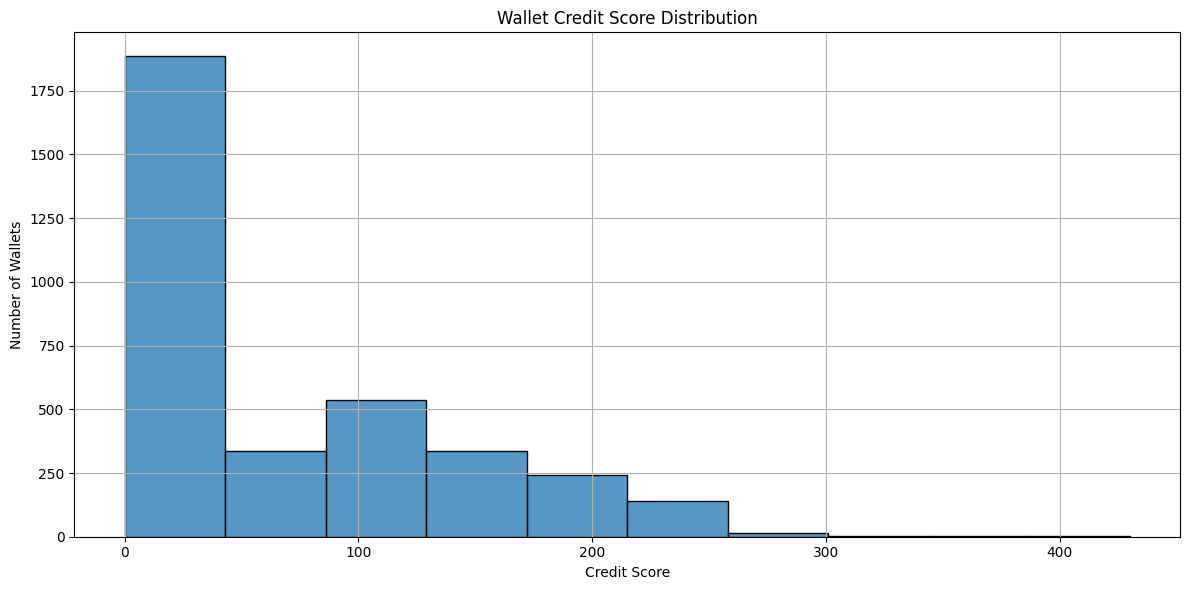

In [106]:
plt.figure(figsize=(12, 6))
sns.histplot(agg_df['credit_score'], bins=10)
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/score_distribution.png")
plt.show()
